In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import hvplot.pandas
warnings.filterwarnings("ignore")
import numpy as np
import scipy.stats as st
from scipy.stats import ttest_ind

In [26]:
test_df = pd.read_csv("data/MERGED2021_22_PP.csv",low_memory=False)

In [4]:
select_columns = test_df[["UNITID", "INSTNM", "CONTROL", "OPENADMP", 
                          "ADM_RATE", "ADM_RATE_ALL", "COSTT4_A", "COSTT4_P"]]
select_columns.head(5)


,UNITID,INSTNM,CONTROL,OPENADMP,ADM_RATE,ADM_RATE_ALL,COSTT4_A,COSTT4_P
0,100654,Alabama A & M University,1,2.0,0.7160,0.716006,21924.0,NaN
1,100663,University of Alabama at Birmingham,1,2.0,0.8854,0.885352,26248.0,NaN
2,100690,Amridge University,2,1.0,NaN,NaN,NaN,NaN
3,100706,University of Alabama in Huntsville,1,2.0,0.7367,0.736724,24869.0,NaN
4,100724,Alabama State University,1,2.0,0.9799,0.979913,21938.0,NaN


In [5]:
# verifying that if there are null values for admission rate then it is a open adm college
indexadm = select_columns[ (select_columns['ADM_RATE'] == 'NaN') & (select_columns['ADM_RATE_ALL'] == 'NaN') & 
                          (select_columns['OPENADMP'] == 2.0) & (select_columns['OPENADMP'] == 3.0) ].index
adm_df = select_columns.drop(indexadm)
adm_df.head(5)


,UNITID,INSTNM,CONTROL,OPENADMP,ADM_RATE,ADM_RATE_ALL,COSTT4_A,COSTT4_P
0,100654,Alabama A & M University,1,2.0,0.7160,0.716006,21924.0,NaN
1,100663,University of Alabama at Birmingham,1,2.0,0.8854,0.885352,26248.0,NaN
2,100690,Amridge University,2,1.0,NaN,NaN,NaN,NaN
3,100706,University of Alabama in Huntsville,1,2.0,0.7367,0.736724,24869.0,NaN
4,100724,Alabama State University,1,2.0,0.9799,0.979913,21938.0,NaN


In [6]:
# dropping rows where both cost columns have null
clean_df = adm_df .dropna(subset=['COSTT4_A', 'COSTT4_P'], how='all')
# merging cost and admission columns
clean_df["cost_merged"] = clean_df["COSTT4_A"].combine_first(clean_df["COSTT4_P"])
clean_df["adm_merged"] = clean_df["ADM_RATE"].combine_first(clean_df["ADM_RATE_ALL"])
clean_df.head(5)


,UNITID,INSTNM,CONTROL,OPENADMP,ADM_RATE,ADM_RATE_ALL,COSTT4_A,COSTT4_P,cost_merged,adm_merged
0,100654,Alabama A & M University,1,2.0,0.7160,0.716006,21924.0,NaN,21924.0,0.7160
1,100663,University of Alabama at Birmingham,1,2.0,0.8854,0.885352,26248.0,NaN,26248.0,0.8854
3,100706,University of Alabama in Huntsville,1,2.0,0.7367,0.736724,24869.0,NaN,24869.0,0.7367
4,100724,Alabama State University,1,2.0,0.9799,0.979913,21938.0,NaN,21938.0,0.9799
5,100751,The University of Alabama,1,2.0,0.7890,0.789043,31050.0,NaN,31050.0,0.7890


In [7]:
#selecting only the needed columns
new_clean_df = clean_df[["UNITID", "INSTNM", "CONTROL", "OPENADMP","cost_merged" ]]
new_clean_df.head(5)

,UNITID,INSTNM,CONTROL,OPENADMP,cost_merged
0,100654,Alabama A & M University,1,2.0,21924.0
1,100663,University of Alabama at Birmingham,1,2.0,26248.0
3,100706,University of Alabama in Huntsville,1,2.0,24869.0
4,100724,Alabama State University,1,2.0,21938.0
5,100751,The University of Alabama,1,2.0,31050.0


In [8]:
# grouping by open adm to get number of colleges in open and non open
group = new_clean_df.groupby("OPENADMP")["UNITID"].count()
group_df = pd.DataFrame(group)
group_df_reset = group_df.reset_index()
group_df_reset

,OPENADMP,UNITID
0,1.0,3412
1,2.0,1883


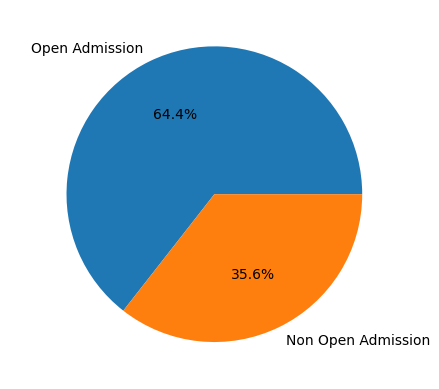

In [229]:
# displaying percentage of open vs non open colleges
labels = ["Open Admission", "Non Open Admission"]
ax = group_df_reset.plot.pie(y='UNITID', labels=labels, autopct='%1.1f%%')
ax.set_ylabel(" ")
ax.legend().set_visible(False)
plt.show()

## Non Open Admission

## Combined

In [206]:
# grouping by openadm and control

combine = new_clean_df.groupby(["OPENADMP", "CONTROL"])["cost_merged"].mean().round()
combine_df = pd.DataFrame(combine)
combine_df_reset = combine_df.reset_index()
combine_df_reset



,OPENADMP,CONTROL,cost_merged
0,1.0,1,14090.0
1,1.0,2,23600.0
2,1.0,3,23356.0
3,2.0,1,22295.0
4,2.0,2,44954.0
5,2.0,3,30837.0


In [12]:
#making the df to pivot so it can be used to plot
pivot = pd.pivot_table(data=combine_df_reset, index=['CONTROL'], 
                       columns=['OPENADMP'], values='cost_merged')
pivot

OPENADMP,1.0,2.0
CONTROL,,
1,14090.0,22295.0
2,23600.0,44954.0
3,23356.0,30837.0


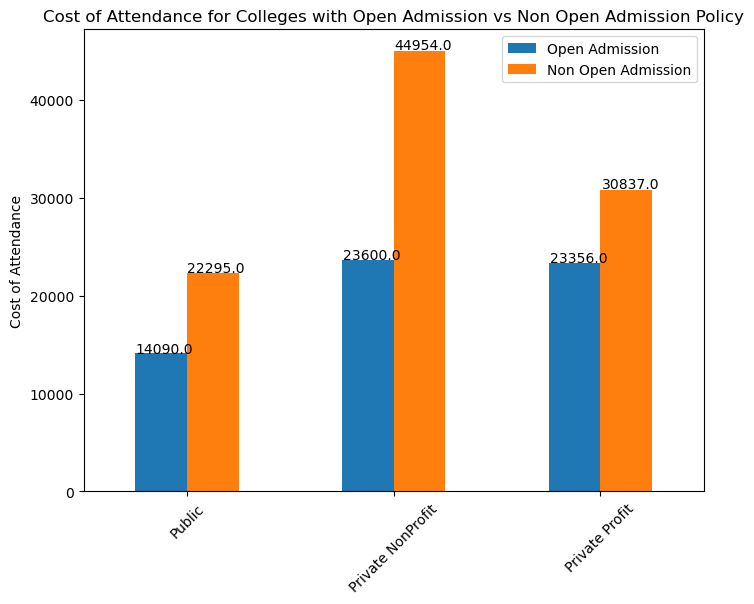

In [164]:
#plotting barchart
cb = pivot.plot(kind='bar', figsize=(8,6), title="Cost of Attendance for Colleges with Open Admission vs Non Open Admission Policy")
combined_labels = ['Public', 'Private NonProfit', 'Private Profit']
cb.set_xticklabels(combined_labels, rotation=45)
cb.set_xlabel("")
cb.set_ylabel("Cost of Attendance")
plt.legend(["Open Admission", "Non Open Admission"])
for p in cb.patches:
    cb.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


## Null Hypothesis for Cost in public and private colleges

In [222]:
# Conducting t test for public and private college cost
# NULL HYPOTHESIS: There is no difference between public and private


# Split the dataset into public and private colleges
public_colleges = new_clean_df[new_clean_df['CONTROL'] == 1]['cost_merged']
private_colleges = new_clean_df[(new_clean_df['CONTROL'] == 3)| (new_clean_df['CONTROL'] == 2)]['cost_merged']

# Perform independent two-sample t-test assuming equal variances
t_statistic, p_value = ttest_ind(public_colleges, private_colleges, equal_var=False)

# Set the significance level
alpha = 0.05

# Compare p-value with the significance level
if p_value < alpha:
    print("There is significant difference in the average cost between public and private colleges.")
else:
    print("There is no significant difference in the average cost between public and private colleges.")

p_value

There is significant difference in the average cost between public and private colleges.


0.0

## Null Hypothesis For Open and Non Open Admission Colleges

In [224]:
# Conducting t test for open and non open admission college cost
# NULL HYPOTHESIS: There is  no difference between open and non open admission


# Split the dataset into public and private colleges
open_colleges = new_clean_df[new_clean_df['OPENADMP'] == 1]['cost_merged']
nonopen_colleges = new_clean_df[(new_clean_df['OPENADMP'] == 2) | (new_clean_df['OPENADMP'] == 3)]['cost_merged']

# Perform independent two-sample t-test assuming equal variances
t_statistic, p_value = ttest_ind(open_colleges, nonopen_colleges, equal_var=False)

# Set the significance level
alpha = 0.05

# Compare p-value with the significance level
if p_value < alpha:
    print("There is significant difference in the average cost between open and non open admission colleges.")
else:
    print("There is no significant difference in the average cost between open and non open admission colleges.")

p_value

There is significant difference in the average cost between open and non open admission colleges.


1.0504334677664811e-266


## Cost of Attendance vs Admission Correlation testing (Non Open Admission)

In [178]:
# filtering to get all non open admission  public colleges
adm_clean_df = clean_df[["UNITID", "INSTNM", "CONTROL", "OPENADMP","cost_merged", "adm_merged" ]]
adm_loc = adm_clean_df.loc[(adm_clean_df["OPENADMP"]== 2.0) | (adm_clean_df["OPENADMP"]== 3.0)]

#dropping null values if any in admission requiremnt column
adm_cost = adm_loc .dropna(subset=["adm_merged"])
adm_cost["adm_merged"] = (adm_cost[["adm_merged"]]*100).round()
adm_cost.head(5)


,UNITID,INSTNM,CONTROL,OPENADMP,cost_merged,adm_merged
0,100654,Alabama A & M University,1,2.0,21924.0,72.0
1,100663,University of Alabama at Birmingham,1,2.0,26248.0,89.0
3,100706,University of Alabama in Huntsville,1,2.0,24869.0,74.0
4,100724,Alabama State University,1,2.0,21938.0,98.0
5,100751,The University of Alabama,1,2.0,31050.0,79.0


<Axes: >

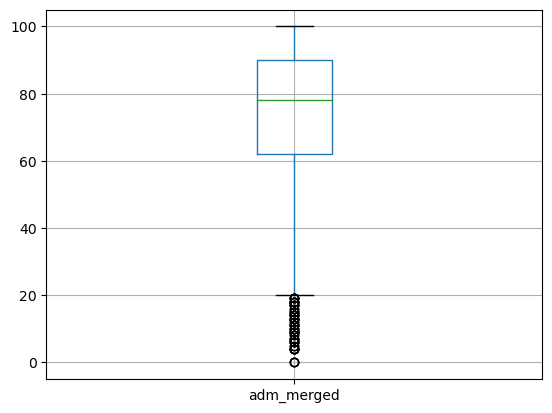

In [172]:
#box plot for admission column
adm_cost.boxplot(column=['adm_merged'])

In [177]:
# removing outliers using iqr
# Calculate the IQR for each column
Q1_col1 = adm_cost['cost_merged'].quantile(0.25)
Q3_col1 = adm_cost['cost_merged'].quantile(0.75)
IQR_col1 = Q3_col1 - Q1_col1

Q1_col2 = adm_cost['adm_merged'].quantile(0.25)
Q3_col2 = adm_cost['adm_merged'].quantile(0.75)
IQR_col2 = Q3_col2 - Q1_col2

# Define the lower and upper bounds for outlier detection
lower_bound_col1 = Q1_col1 - 1.5 * IQR_col1
upper_bound_col1 = Q3_col1 + 1.5 * IQR_col1

lower_bound_col2 = Q1_col2 - 1.5 * IQR_col2
upper_bound_col2 = Q3_col2 + 1.5 * IQR_col2


# Filter out rows with values outside the lower and upper bounds for both columns
df_no_outliers = adm_cost[(adm_cost['cost_merged'] >= lower_bound_col1) & 
                          (adm_cost['cost_merged'] <= upper_bound_col1) & 
                          (adm_cost['adm_merged'] >= lower_bound_col2) & 
                          (adm_cost['adm_merged'] <= upper_bound_col2)]
df_no_outliers.head(5)

,UNITID,INSTNM,CONTROL,OPENADMP,cost_merged,adm_merged
0,100654,Alabama A & M University,1,2.0,21924.0,72.0
1,100663,University of Alabama at Birmingham,1,2.0,26248.0,89.0
3,100706,University of Alabama in Huntsville,1,2.0,24869.0,74.0
4,100724,Alabama State University,1,2.0,21938.0,98.0
5,100751,The University of Alabama,1,2.0,31050.0,79.0


The correlation between cost and admission rate for public is-0.2


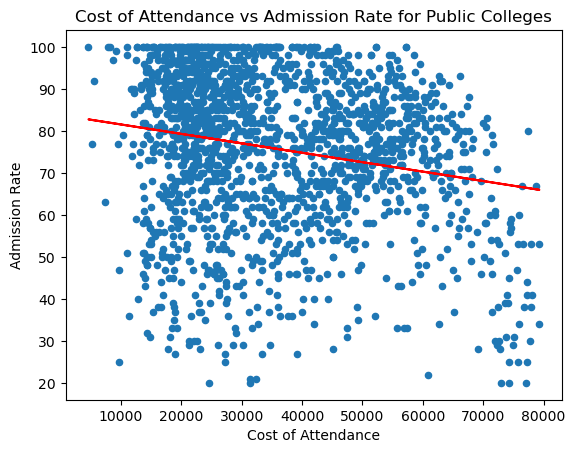

In [175]:
# creating scatter plot for admission rate vs cost(without outliers)

pb_sc_ot= df_no_outliers.plot.scatter(x="cost_merged", y="adm_merged", 
                                   title="Cost of Attendance vs Admission Rate for Public Colleges")
pb_sc_ot.set_xlabel("Cost of Attendance")
pb_sc_ot.set_ylabel("Admission Rate")
cost = df_no_outliers["cost_merged"]
adm_rate = df_no_outliers["adm_merged"]
m, b = np.polyfit(cost, adm_rate, 1)
plt.plot(cost, m*cost+b, color='red', label='x={:.2f}y+{:.2f}'.format(m,b))

correlation = st.pearsonr(cost, adm_rate)
print(f"The correlation between cost and admission rate for public is{round(correlation[0],2)}")
